In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import xgboost as xb
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', None)
from sklearn.metrics import accuracy_score

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flu-shot-prediction/training_set_features.csv
/kaggle/input/flu-shot-prediction/test_set_features.csv
/kaggle/input/flu-shot-prediction/training_set_labels.csv
/kaggle/input/flu-shot-prediction/submission_format.csv


In [7]:
data = pd.read_csv('/kaggle/input/flu-shot-prediction/training_set_features.csv')
labels = pd.read_csv('/kaggle/input/flu-shot-prediction/training_set_labels.csv')

In [8]:
data.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


In [9]:
data_f = data.fillna(-1)

In [10]:
from sklearn.model_selection import train_test_split, StratifiedKFold

In [11]:
X_train, X_test, y_train, y_test = train_test_split(data_f, labels['h1n1_vaccine'], test_size=0.2, random_state=42)

In [12]:
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

In [13]:
X_train.drop('respondent_id', axis=1,inplace=True)
X_test.drop('respondent_id', axis=1, inplace=True)

In [14]:
X_train = X_train.astype('int32')
X_test = X_test.astype('int32')

In [15]:
X_train.rename(columns={'education_< 12 Years':'education_less_12 Years', 'income_poverty_<= $75,000, Above Poverty' : 'income_poverty_less equal $75,000, Above Poverty', 'income_poverty_> $75,000':'income_poverty_more $75,000'}, inplace=True)
X_test.rename(columns={'education_< 12 Years':'education_less_12 Years', 'income_poverty_<= $75,000, Above Poverty' : 'income_poverty_less equal $75,000, Above Poverty', 'income_poverty_> $75,000':'income_poverty_more $75,000'}, inplace=True)



In [16]:
from xgboost import XGBClassifier

In [17]:
xgb = XGBClassifier(tree_method='gpu_hist')

In [18]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [19]:
y_pred = xgb.predict(X_test)

In [20]:
y_pred

array([0, 0, 0, ..., 1, 0, 0])

In [24]:
roc_auc_score(y_test,y_pred)

0.7293451495516392

In [18]:
accuracy_score(y_test, y_pred)

0.850430550355672

In [27]:
# param_grid = {'max_depth':[3,5,6,10,15,20],
#               'learning_rate':[0.01,0.1,0.2,0.3],
#               'subsample':np.arange(0.5,1.0,0.1),
#               'colsample_bytree':np.arange(0.4,1.0,0.1),
#               'colsample_bylevel':np.arange(0.4,1.0,0.1),
#               'n_estimators':[100,500,1000],
#               'reg_alpha':[0,0.5,1,5],
#               'reg_lambda':[0,0.5,1,5]}

param_grid = {'learning_rate':[0.1, 0.2],
          'max_depth':[3, 6, 9],
          'min_child_weight':[1, 5],
          'subsample': [0.7, 1],
          'colsample_bytree':[0.7, 1]}

# param_grid = {'learning_rate':[0.1, 0.2],
#           'max_depth':[3, 6, 9],
#           'min_child_weight':[1, 5],
#           'subsample': [0.7, 1],
#           'colsample_bytree':[0.7, 1],
#           'n_estimators':[500,1000]}

scoring = ['recall']
#kfold = StratifiedKFold(n_splits=3,shuffle=True,random_state=0)

In [28]:
from sklearn.model_selection import GridSearchCV

In [29]:
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid,scoring=scoring,refit='recall',n_jobs=-1,cv=5,verbose=3)

In [22]:
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.7; recall: (test=0.498) total time=   5.6s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.7; recall: (test=0.509) total time=   1.7s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.7; recall: (test=0.509) total time=   1.7s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=500, subsample=1; recall: (test=0.549) total time=   1.7s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=500, subsample=1; recall: (test=0.505) total time=   1.7s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=1000, subsample=0.7; recall: (test=0.535) 

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     callbacks=None, colsample_bylevel=1,
                                     colsample_bynode=1, colsample_bytree=1,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=0, gpu_id=0, grow_policy='depthwise',
                                     importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.300000012, max_bin=256,
                                     max_cat...
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=100, n_jobs=0,
                                     num_parallel_tree=1, predictor='auto',
        

In [23]:
print(grid_search.best_params_)

{'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 1000, 'subsample': 0.7}


In [70]:
XGB_h1n1 = XGBClassifier(colsample_bytree = 1, learning_rate = 0.2, max_depth = 9, min_child_weight = 5, subsample = 0.7)
#XGB_h1n1 = XGBClassifier(colsample_bytree = 0.7, learning_rate = 0.2, max_depth = 3, min_child_weight = 1, subsample = 0.7, n_estimators = 1000)
XGB_h1n1.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [71]:
grid_pred_h1n1 = XGB_h1n1.predict(X_test)

In [72]:
accuracy_score(y_test,grid_pred_h1n1)

0.8494945713216024

In [73]:
y_prob_h1n1 = XGB_h1n1.predict_proba(X_test)[:,1]

In [2]:
from sklearn.metrics import roc_auc_score

In [75]:
roc_auc_score(y_test, y_prob_h1n1)

0.8591466438074108


[CV 4/5] END colsample_bytree=1, learning_rate=0.2, max_depth=9, min_child_weight=1, n_estimators=1000, subsample=1; recall: (test=0.730) total time=  34.0s
[CV 1/5] END colsample_bytree=1, learning_rate=0.2, max_depth=9, min_child_weight=5, n_estimators=500, subsample=0.7; recall: (test=0.726) total time=  13.1s
[CV 3/5] END colsample_bytree=1, learning_rate=0.2, max_depth=9, min_child_weight=5, n_estimators=500, subsample=0.7; recall: (test=0.735) total time=  13.9s
[CV 5/5] END colsample_bytree=1, learning_rate=0.2, max_depth=9, min_child_weight=5, n_estimators=500, subsample=0.7; recall: (test=0.737) total time=  13.5s
[CV 2/5] END colsample_bytree=1, learning_rate=0.2, max_depth=9, min_child_weight=5, n_estimators=500, subsample=1; recall: (test=0.726) total time=  13.7s
[CV 4/5] END colsample_bytree=1, learning_rate=0.2, max_depth=9, min_child_weight=5, n_estimators=500, subsample=1; recall: (test=0.739) total time=  13.3s
[CV 1/5] END colsample_bytree=1, learning_rate=0.2, max_

## XGBoost model seasonal

In [30]:
X_train, X_test, y_train_seas, y_test_seas = train_test_split(data_f, labels['seasonal_vaccine'], test_size=0.2, random_state=42)

In [31]:
# X_test

In [32]:
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

In [33]:
X_train.drop('respondent_id', axis=1,inplace=True)
X_test.drop('respondent_id', axis=1, inplace=True)

In [34]:
X_train = X_train.astype('int32')
X_test = X_test.astype('int32')

In [35]:
X_train.rename(columns={'education_< 12 Years':'education_less_12 Years', 'income_poverty_<= $75,000, Above Poverty' : 'income_poverty_less equal $75,000, Above Poverty', 'income_poverty_> $75,000':'income_poverty_more $75,000'}, inplace=True)
X_test.rename(columns={'education_< 12 Years':'education_less_12 Years', 'income_poverty_<= $75,000, Above Poverty' : 'income_poverty_less equal $75,000, Above Poverty', 'income_poverty_> $75,000':'income_poverty_more $75,000'}, inplace=True)


In [36]:
xgb1 = XGBClassifier(tree_method='gpu_hist')

In [37]:
xgb1.fit(X_train, y_train_seas)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [38]:
y_pred_seas = xgb1.predict(X_test)

In [39]:
y_pred_seas

array([0, 0, 1, ..., 1, 1, 1])

In [40]:
accuracy_score(y_test_seas, y_pred_seas)

0.7864095844253088

In [41]:
# params = {'colsample_bytree': 1, 
#           'learning_rate': 0.2, 
#           'max_depth': 9, 
#           'min_child_weight': 5, 
#           'subsample': 0.7}

# param_grid_seas = {'learning_rate':[0.1, 0.2],
#           'max_depth':[3, 6, 9],
#           'min_child_weight':[1, 5],
#           'subsample': [0.7, 1],
#           'colsample_bytree':[0.7, 1]}

param_grid = {'learning_rate':[0.1, 0.2],
          'max_depth':[3, 6, 9],
          'min_child_weight':[1, 5],
          'subsample': [0.7, 1],
          'colsample_bytree':[0.7, 1],
          'n_estimators':[500,1000]}

scoring = ['recall']

In [42]:
from sklearn.model_selection import GridSearchCV

In [43]:
grid_search_seas = GridSearchCV(estimator=xgb1, param_grid=param_grid,scoring=scoring,refit='recall',n_jobs=-1,cv=5,verbose=3)

In [44]:
grid_search_seas.fit(X_train,y_train_seas)

Fitting 5 folds for each of 96 candidates, totalling 480 fits

[CV 3/5] END colsample_bytree=1, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=1000, subsample=1; recall: (test=0.543) total time=  12.8s
[CV 5/5] END colsample_bytree=1, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=1000, subsample=1; recall: (test=0.530) total time=  12.7s
[CV 2/5] END colsample_bytree=1, learning_rate=0.2, max_depth=6, min_child_weight=5, n_estimators=500, subsample=0.7; recall: (test=0.515) total time=   5.6s
[CV 4/5] END colsample_bytree=1, learning_rate=0.2, max_depth=6, min_child_weight=5, n_estimators=500, subsample=0.7; recall: (test=0.514) total time=   5.5s
[CV 1/5] END colsample_bytree=1, learning_rate=0.2, max_depth=6, min_child_weight=5, n_estimators=500, subsample=1; recall: (test=0.509) total time=   5.1s
[CV 3/5] END colsample_bytree=1, learning_rate=0.2, max_depth=6, min_child_weight=5, n_estimators=500, subsample=1; recall: (test=0.546) total time=   

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     callbacks=None, colsample_bylevel=1,
                                     colsample_bynode=1, colsample_bytree=1,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=0, gpu_id=0, grow_policy='depthwise',
                                     importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.300000012, max_bin=256,
                                     max_cat...
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=100, n_jobs=0,
                                     num_parallel_tree=1, predictor='auto',
        

In [45]:
print(grid_search_seas.best_params_)

{'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 1}


In [76]:
# XGB_seas = XGBClassifier(colsample_bytree = 0.7, learning_rate = 0.1, max_depth = 6, min_child_weight = 5, subsample = 1)
XGB_seas = XGBClassifier(colsample_bytree = 0.7, learning_rate = 0.2, max_depth = 3, min_child_weight = 5, subsample = 1, n_estimators = 500)

XGB_seas.fit(X_train,y_train_seas)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=5,
              missing=nan, monotone_constraints='()', n_estimators=500,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [77]:
grid_pred_seas = XGB_seas.predict(X_test)

In [78]:
grid_pred_seas

array([0, 0, 1, ..., 1, 0, 1])

In [79]:
accuracy_score(y_test_seas,grid_pred_seas)

0.793897416697866

In [80]:
y_prob_seas = XGB_seas.predict_proba(X_test)[:,1]

In [81]:
roc_auc_score(y_test_seas, y_prob_seas)

0.8662254769758453

## Test Imputation

In [82]:
test_data = pd.read_csv("/kaggle/input/flu-shot-prediction/test_set_features.csv")

In [83]:
test_data

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,26707,2.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,1.0,1.0,5.0,1.0,1.0,35 - 44 Years,College Graduate,Hispanic,Female,"> $75,000",Not Married,Rent,Employed,mlyzmhmf,"MSA, Not Principle City",1.0,0.0,atmlpfrs,hfxkjkmi
1,26708,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,1.0,4.0,1.0,1.0,18 - 34 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,Non-MSA,3.0,0.0,atmlpfrs,xqwwgdyp
2,26709,2.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,5.0,4.0,2.0,5.0,4.0,4.0,55 - 64 Years,College Graduate,White,Male,"> $75,000",Married,Own,Employed,lrircsnp,Non-MSA,1.0,0.0,nduyfdeo,pvmttkik
3,26710,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,4.0,2.0,2.0,4.0,4.0,2.0,65+ Years,12 Years,White,Female,"<= $75,000, Above Poverty",Married,Own,Not in Labor Force,lrircsnp,"MSA, Not Principle City",1.0,0.0,NaN,NaN
4,26711,3.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,5.0,2.0,4.0,4.0,4.0,2.0,35 - 44 Years,12 Years,Black,Female,"<= $75,000, Above Poverty",Not Married,Own,Employed,lzgpxyit,Non-MSA,0.0,1.0,fcxhlnwr,mxkfnird
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26703,53410,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,NaN,4.0,2.0,2.0,4.0,2.0,1.0,35 - 44 Years,NaN,White,Female,NaN,NaN,NaN,NaN,dqpwygqj,"MSA, Principle City",1.0,1.0,NaN,NaN
26704,53411,3.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,1.0,1.0,5.0,2.0,2.0,18 - 34 Years,12 Years,White,Male,Below Poverty,Married,Rent,Employed,qufhixun,Non-MSA,1.0,3.0,fcxhlnwr,vlluhbov
26705,53412,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,3.0,1.0,4.0,3.0,1.0,18 - 34 Years,Some College,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,qufhixun,"MSA, Not Principle City",1.0,0.0,NaN,NaN
26706,53413,3.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,2.0,3.0,4.0,4.0,3.0,2.0,55 - 64 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Not in Labor Force,bhuqouqj,"MSA, Not Principle City",1.0,0.0,NaN,NaN


In [84]:
test_data_f = test_data.fillna(-1)

In [85]:
test_data_f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26708 entries, 0 to 26707
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26708 non-null  int64  
 1   h1n1_concern                 26708 non-null  float64
 2   h1n1_knowledge               26708 non-null  float64
 3   behavioral_antiviral_meds    26708 non-null  float64
 4   behavioral_avoidance         26708 non-null  float64
 5   behavioral_face_mask         26708 non-null  float64
 6   behavioral_wash_hands        26708 non-null  float64
 7   behavioral_large_gatherings  26708 non-null  float64
 8   behavioral_outside_home      26708 non-null  float64
 9   behavioral_touch_face        26708 non-null  float64
 10  doctor_recc_h1n1             26708 non-null  float64
 11  doctor_recc_seasonal         26708 non-null  float64
 12  chronic_med_condition        26708 non-null  float64
 13  child_under_6_mo

In [86]:
test_data_f.isna().sum()

respondent_id                  0
h1n1_concern                   0
h1n1_knowledge                 0
behavioral_antiviral_meds      0
behavioral_avoidance           0
behavioral_face_mask           0
behavioral_wash_hands          0
behavioral_large_gatherings    0
behavioral_outside_home        0
behavioral_touch_face          0
doctor_recc_h1n1               0
doctor_recc_seasonal           0
chronic_med_condition          0
child_under_6_months           0
health_worker                  0
health_insurance               0
opinion_h1n1_vacc_effective    0
opinion_h1n1_risk              0
opinion_h1n1_sick_from_vacc    0
opinion_seas_vacc_effective    0
opinion_seas_risk              0
opinion_seas_sick_from_vacc    0
age_group                      0
education                      0
race                           0
sex                            0
income_poverty                 0
marital_status                 0
rent_or_own                    0
employment_status              0
hhs_geo_re

In [87]:
test_data_f = pd.get_dummies(test_data_f, drop_first=True)

In [88]:
test_data_f.isna().sum()

respondent_id                     0
h1n1_concern                      0
h1n1_knowledge                    0
behavioral_antiviral_meds         0
behavioral_avoidance              0
                                 ..
employment_occupation_vlluhbov    0
employment_occupation_xgwztkwe    0
employment_occupation_xqwwgdyp    0
employment_occupation_xtkaffoo    0
employment_occupation_xzmlyyjv    0
Length: 101, dtype: int64

In [89]:
test_data_f = test_data_f.astype('int32')

In [90]:
test_data_f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26708 entries, 0 to 26707
Columns: 101 entries, respondent_id to employment_occupation_xzmlyyjv
dtypes: int32(101)
memory usage: 10.3 MB


In [91]:
test_data_f.rename(columns={'education_< 12 Years':'education_less_12 Years', 'income_poverty_<= $75,000, Above Poverty' : 'income_poverty_less equal $75,000, Above Poverty', 'income_poverty_> $75,000':'income_poverty_more $75,000'}, inplace=True)

In [92]:
test_data_f

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,education_12 Years,education_less_12 Years,education_College Graduate,education_Some College,race_Hispanic,race_Other or Multiple,race_White,sex_Male,"income_poverty_less equal $75,000, Above Poverty","income_poverty_more $75,000",income_poverty_Below Poverty,marital_status_Married,marital_status_Not Married,rent_or_own_Own,rent_or_own_Rent,employment_status_Employed,employment_status_Not in Labor Force,employment_status_Unemployed,hhs_geo_region_bhuqouqj,hhs_geo_region_dqpwygqj,hhs_geo_region_fpwskwrf,hhs_geo_region_kbazzjca,hhs_geo_region_lrircsnp,hhs_geo_region_lzgpxyit,hhs_geo_region_mlyzmhmf,hhs_geo_region_oxchjgsf,hhs_geo_region_qufhixun,"census_msa_MSA, Principle City",census_msa_Non-MSA,employment_industry_arjwrbjb,employment_industry_atmlpfrs,employment_industry_cfqqtusy,employment_industry_dotnnunm,employment_industry_fcxhlnwr,employment_industry_haxffmxo,employment_industry_ldnlellj,employment_industry_mcubkhph,employment_industry_mfikgejo,employment_industry_msuufmds,employment_industry_nduyfdeo,employment_industry_phxvnwax,employment_industry_pxcmvdjn,employment_industry_qnlwzans,employment_industry_rucpziij,employment_industry_saaquncn,employment_industry_vjjrobsf,employment_industry_wlfvacwt,employment_industry_wxleyezf,employment_industry_xicduogh,employment_industry_xqicxuve,employment_occupation_bxpfxfdn,employment_occupation_ccgxvspp,employment_occupation_cmhcxjea,employment_occupation_dcjcmpih,employment_occupation_dlvbwzss,employment_occupation_emcorrxb,employment_occupation_haliazsg,employment_occupation_hfxkjkmi,employment_occupation_hodpvpew,employment_occupation_kldqjyjy,employment_occupation_mxkfnird,employment_occupation_oijqvulv,employment_occupation_pvmttkik,employment_occupation_qxajmpny,employment_occupation_rcertsgn,employment_occupation_tfqavkke,employment_occupation_ukymxvdu,employment_occupation_uqqtjvyb,employment_occupation_vlluhbov,employment_occupation_xgwztkwe,employment_occupation_xqwwgdyp,employment_occupation_xtkaffoo,employment_occupation_xzmlyyjv
0,26707,2,2,0,1,0,1,1,0,1,0,0,0,0,0,1,5,1,1,5,1,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,26708,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,4,1,1,4,1,1,3,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,26709,2,2,0,0,1,1,1,1,1,0,0,0,0,0,-1,5,4,2,5,4,4,1,0,0,0,1,0,0,0,1,0,0,0,1,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,26710,1,1,0,0,0,0,0,0,0,1,1,1,0,0,1,4,2,2,4,4,2,1,0,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,26711,3,1,1,1,0,1,1,1,1,0,0,0,0,1,1,5,2,4,4,4,2,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [93]:
test_data_f = test_data_f.iloc[:,1:]

In [94]:
test_data_f

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,education_12 Years,education_less_12 Years,education_College Graduate,education_Some College,race_Hispanic,race_Other or Multiple,race_White,sex_Male,"income_poverty_less equal $75,000, Above Poverty","income_poverty_more $75,000",income_poverty_Below Poverty,marital_status_Married,marital_status_Not Married,rent_or_own_Own,rent_or_own_Rent,employment_status_Employed,employment_status_Not in Labor Force,employment_status_Unemployed,hhs_geo_region_bhuqouqj,hhs_geo_region_dqpwygqj,hhs_geo_region_fpwskwrf,hhs_geo_region_kbazzjca,hhs_geo_region_lrircsnp,hhs_geo_region_lzgpxyit,hhs_geo_region_mlyzmhmf,hhs_geo_region_oxchjgsf,hhs_geo_region_qufhixun,"census_msa_MSA, Principle City",census_msa_Non-MSA,employment_industry_arjwrbjb,employment_industry_atmlpfrs,employment_industry_cfqqtusy,employment_industry_dotnnunm,employment_industry_fcxhlnwr,employment_industry_haxffmxo,employment_industry_ldnlellj,employment_industry_mcubkhph,employment_industry_mfikgejo,employment_industry_msuufmds,employment_industry_nduyfdeo,employment_industry_phxvnwax,employment_industry_pxcmvdjn,employment_industry_qnlwzans,employment_industry_rucpziij,employment_industry_saaquncn,employment_industry_vjjrobsf,employment_industry_wlfvacwt,employment_industry_wxleyezf,employment_industry_xicduogh,employment_industry_xqicxuve,employment_occupation_bxpfxfdn,employment_occupation_ccgxvspp,employment_occupation_cmhcxjea,employment_occupation_dcjcmpih,employment_occupation_dlvbwzss,employment_occupation_emcorrxb,employment_occupation_haliazsg,employment_occupation_hfxkjkmi,employment_occupation_hodpvpew,employment_occupation_kldqjyjy,employment_occupation_mxkfnird,employment_occupation_oijqvulv,employment_occupation_pvmttkik,employment_occupation_qxajmpny,employment_occupation_rcertsgn,employment_occupation_tfqavkke,employment_occupation_ukymxvdu,employment_occupation_uqqtjvyb,employment_occupation_vlluhbov,employment_occupation_xgwztkwe,employment_occupation_xqwwgdyp,employment_occupation_xtkaffoo,employment_occupation_xzmlyyjv
0,2,2,0,1,0,1,1,0,1,0,0,0,0,0,1,5,1,1,5,1,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,4,1,1,4,1,1,3,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,2,2,0,0,1,1,1,1,1,0,0,0,0,0,-1,5,4,2,5,4,4,1,0,0,0,1,0,0,0,1,0,0,0,1,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,1,1,1,0,0,1,4,2,2,4,4,2,1,0,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3,1,1,1,0,1,1,1,1,0,0,0,0,1,1,5,2,4,4,4,2,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [95]:
h1n1_prediction = XGB_h1n1.predict_proba(test_data_f)[:,1]

In [96]:
seas_prediction = XGB_seas.predict_proba(test_data_f)[:,1]

In [97]:
n_test_d = pd.read_csv('/kaggle/input/flu-shot-prediction/test_set_features.csv')

In [98]:
pd.DataFrame(data={'h1n1_vaccine': h1n1_prediction, 'seasonal_vaccine': seas_prediction}, index=n_test_d['respondent_id']).to_csv('submission12.csv')

In [25]:
from sklearn.metrics import roc_curve, auc


In [26]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob_h1n1)

NameError: name 'y_prob_h1n1' is not defined

In [22]:
auc_score = auc(fpr, tpr)

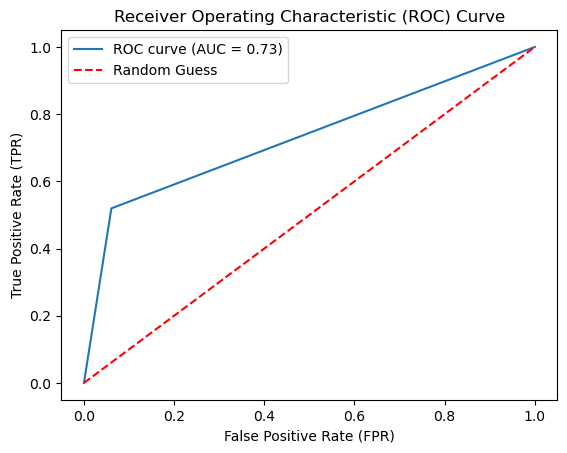

In [23]:
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random Guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()